<div style="max-width:1200px"><img src="../_resources/mgnify_banner.png" width="100%"></div>

# Taxonomic and functional annotations in MGnify

**Aims:**

- **Learn to fetch data from MGnify using MGnifyR** 
- **Comparing taxonomic annotations**
- **Comparing functional annotations**

**This notebook is written in R**

<div style="background: #d0debb; padding: 16px; border-radius: 4px; margin: 8px">
This is an interactive code notebook (a Jupyter Notebook). To run this code, click into each cell and press the ▶ button in the top toolbar, or press shift+enter
</div>

In [50]:
# Loading libraries:
suppressMessages({
    library(ggplot2)
    library(IRdisplay)    
    library(MGnifyR)
    library(microbiomeMarker)
    library(plyr)
    library(tidyverse)
    library(vegan)
    library(phyloseq)
})

In [18]:
# Setting tables and figures size to display (these will be reset later):
options(repr.matrix.max.cols=150, repr.matrix.max.rows=200)
options(repr.plot.width=4, repr.plot.height=4)

# Fetching data from MGnify

There are several ways to download data from MGnify, some of which include: manually via the website, via the MGnify API or using MGnifyR. In this tutorial we will show you examples using MGnifyR.

[MGnifyR](http://github.com/beadyallen/mgnifyr) is a library that provides a set of tools for easily accessing and processing MGnify data in R, making queries to MGnify databases through the [MGnify API](https://www.ebi.ac.uk/metagenomics/api/v1/). 
The benefit of MGnifyR is that data can either be fetched in tsv format or be directly combined in a phyloseq object to run an analysis in a custom workflow.

In [19]:
# Run this cell for further information about MGnifyR
display_markdown(file = '../_resources/mgnifyr_help.md')

# Help with MGnifyR

MGnifyR is an R package that provides a convenient way for R users to access data from [the MGnify API](https://www.ebi.ac.uk/metagenomics/api/).

Detailed help for each function is available in R using the standard `?function_name` command (i.e. typing `?mgnify_query` will bring up built-in help for the mgnify_query command). 

A vignette is available containing a reasonably verbose overview of the main functionality. 
This can be read either within R with the `vignette("MGnifyR")` command, or [in the development repository](https://htmlpreview.github.io/?https://github.com/beadyallen/MGnifyR/blob/master/doc/MGnifyR.html)

## MGnifyR Command cheat sheet

The following list of key functions should give a starting point for finding relevent documentation.

- `mgnify_client()` : Create the client object required for all other functions.
- `mgnify_query()` : Search the whole MGnify database.
- `mgnify_analyses_from_xxx()` : Convert xxx accessions to analyses accessions. xxx is either samples or studies.
- `mgnify_get_analyses_metadata()` : Retrieve all study, sample and analysis metadata for given analyses.
- `mgnify_get_analyses_phyloseq()` : Convert abundance, taxonomic, and sample metadata into a single phyloseq object.
- `mgnify_get_analyses_results()` : Get functional annotation results for a set of analyses.
- `mgnify_download()` : Download raw results files from MGnify.
- `mgnify_retrieve_json()` : Low level API access helper function.


## Contents
- [Part 1. Fetching data and preprocessing](#part1)
  - [1.1. Fetch the MGnify Analyses accession](#part1_1)
  - [1.2. Explore and filter samples by metadata](#part1_2)
  - [1.3. Converting into phyloseq object](#part1_3)
- [Part 2. Normalization, alpha diversity indices and taxonomic profiles visualization](#part2)
   - [2.1. Cleaning the OTUs matrix](#part2_1)
   - [2.2. Normalization by total sum scaling (TSS, relative abundance or proportions)](#part2_2)
   - [2.3. Normalization by subsampling (rarefaction)](#part2_3)
   - [2.4. Normalization by cumulative sum scaling (CSS)](#part2_4)
   - [2.5. Computing alpha diversity indices](#part2_5)
   - [2.6. Community profile visualization](#part2_6)
- [Part 4. Exploring KEGG pathways](#part3)
    - [4.1 Fetch data from MGnify & Pathways Selection](#part3_1)
    - [4.2 Select the most complete pathways](#part3_2)
    - [4.3 Ready to draw!](#part3_3)

## Part 1. Fetching data and preprocessing <a id='part1'/>

In this example we are going to fetch MGnify analysis results and metadata for TARA ocean metagenomic study corresponding to size fractions for prokaryotes ([MGYS00002008](https://www.ebi.ac.uk/metagenomics/studies/MGYS00002008#overview)).
Find more information about the [TARA Ocean Project.](https://fondationtaraocean.org/en/expedition/tara-oceans/)

### 1.1. Fetch the MGnify Analyses accession <a id='part1_1'/>

1. The first step is to retrieve the analysis accession list.

In [21]:
# Create your session mgnify_client object
mg = mgnify_client(usecache = T, cache_dir = '/home/jovyan/.mgnify_cache')
tara_all = mgnify_analyses_from_studies(mg, 'MGYS00002008')

  |======================================================================| 100%


2. Use the list of accessions to fetch the metadata for all of the analyses from the MGnify API.

In [22]:
metadata = mgnify_get_analyses_metadata(mg, tara_all)

  |======================================================================| 100%


<div class="alert alert-block alert-info">
<b>Tip:</b> In case you are interested in running the comparative metagenomic analysis using data from different studies in MGnify, you can adapt the following commands:
</div>
 
    
```R
analyses_accessions = mgnify_analyses_from_studies(mg, c("MGYS1","MGYS2"))

metadata = mgnify_get_analyses_metadata(mg, analyses_accessions)
```

1) Check the number of analyses in the study.

In [23]:
length(metadata$'analysis_accession')

[1] 497

2) Check the `analysis_experiment-type` to determine whether a filtering is necesary to discard amplicon samples, and check which versions of the analysis pipeline were used.

In [28]:
unique(metadata$'analysis_experiment-type')
unique(metadata$'analysis_pipeline-version')

[1] "assembly"

[1] "5.0" "4.1" "4.0"

3) Only assembly results exist so we don't need to filter out amplicon. Keep results generated only with the most updated pipeline (v5.0).

In [29]:
v5_metadata = metadata[which(metadata$'analysis_pipeline-version'=='5.0'), ]

4) Check the `sample_environment-feature` to discover what kind of samples are part of the study and how many of each exists.

<div class="alert alert-block alert-info">
<b>Note:</b> For a comparative study, we need at least 5 samples per group
</div>

In [35]:
table(v5_metadata$'sample_environment-feature')


                                   deep chlorophyll maximum layer (ENVO:xxxxxxxx) 
                                                                               76 
                                   marine epipelagic mixed layer (ENVO:xxxxxxxxx) 
                                                                                9 
                                                 mesopelagic zone (ENVO:00000213) 
                                                                               43 
mesopelagic zone (ENVO:00000213) &amp; marine oxygen minimum zone (ENVO:01000065) 
                                                                               13 
                                              surface water (ENVO:00002042) layer 
                                                                                6 
                                              surface water layer (ENVO:00002042) 
                                                                              100 
   

5. Filtering out noisy samples.

We want to create a new dataframe containing the relevant samples. In this step, we will also create a clean label for the environment feature. Additionally, we noticed that some samples have extreme default values in the metadata. We will filter out those samples to reduce the noise on the analysis.

<div class="alert alert-block alert-info">
<b>Note:</b> To speed up the following analysis, we are going to keep only 34 samples per group (by randomly subsampling the table)
</div>

In [39]:
# Saving the list of Surface water samples in a dataframe
sub1 = v5_metadata[str_detect(v5_metadata$'sample_environment-feature', "surface"), ]

# Reducing the metadata table to keep relevant fields only
variables_to_keep = c('sample_temperature','sample_depth','sample_salinity','sample_chlorophyll sensor','sample_nitrate sensor','sample_oxygen sensor')
reduced_sub1 = sub1[variables_to_keep]

# Removing rows with extreme values
reduced_sub1[reduced_sub1 == "99999"] <- NA
reduced_sub1[reduced_sub1 == "99999.0"] <- NA
reduced_sub1[reduced_sub1 == "0"] <- NA

clean1=na.omit(reduced_sub1)

# Subsampling to 34
set.seed(345)
random_1 = clean1[sample(nrow(clean1), 34), ]
random_1$'env_label'=c(rep('Surface', times=length(rownames(random_1))))

In [40]:
# Saving the list of Mesopelagic zone samples in a dataframe
sub2 = v5_metadata[str_detect(v5_metadata$'sample_environment-feature', "mesopelagic"), ]

# Reducing the metadata table to keep relevant fields only
reduced_sub2 = sub2[variables_to_keep]

# Removing rows with extreme values
reduced_sub2[reduced_sub2 == "99999"] <- NA
reduced_sub2[reduced_sub2 == "99999.0"] <- NA
reduced_sub2[reduced_sub2 == "0"] <- NA

clean2=na.omit(reduced_sub2)

# Subsampling to 34
set.seed(345)
random_2 = clean2[sample(nrow(clean2), 34), ]
random_2$'env_label'=c(rep('Mesopelagic', times=length(rownames(random_2))))

In [47]:
clean_metadata=rbind(random_1,random_2)
clean_acc=rownames(clean_metadata)

### 1.3. Converting into phyloseq object <a id='part1_3'/>

1. Now that we have a new dataframe with samples from either surface or mesopelagic zone water, we are going to create the phyloseq object. 

Phyloseq is a package to store and analyse operational taxonomic units (OTUs), and a phyloseq object associates information such as sample data to the taxonomic units. Within MGnify taxonomic annotation is performed on predicted marker gene regions such as SSU and LSU rRNA.

<div class="alert alert-block alert-info">
<b>Note:</b> This example is used for this notebook is for continuity in order to use the same study. It is difficult to resolve full length marker genes from short read shotgun metagenomes even with assembly. Therefore taxonomic summaries on metagenomic assemblies based on nuleotide marker genes should be used with caution. This process may be more robust for targeted amplicon data or long-read sequenced metagenomes.
</div>

In [48]:
ps = mgnify_get_analyses_phyloseq(mg, clean_acc)

  |======================================================================| 100%


2. Keep only relevant columns in the phyloseq metadata table and transform numeric variables from characters to numbers. Add the environment label as well.

In [51]:
# Keeping relevant metadata in the phyloseq object
variables_to_keep = c('sample_temperature','sample_depth','sample_salinity','sample_chlorophyll.sensor','sample_nitrate.sensor','sample_oxygen.sensor')
df = data.frame(sample_data(ps))[variables_to_keep]

# Transforming character to numeric variables
df[] = lapply(df, function(x) as.numeric(as.character(x)))
sample_data(ps) = df

# Adding the env label                              
sample_data(ps)$'env_label' = clean_metadata$env_label

In [2]:
head(sample_data(ps))

ERROR: Error in sample_data(ps): could not find function "sample_data"


## Part 2. Normalization, alpha diversity indices and taxonomic profiles visualization <a id='part2'/>

### 2.1. Cleaning the OTUs matrix <a id='part2_1'/>

1) Remove samples with extremely low coverage – they aren't informative and interfere with the normalization process. The first step is to detect outliers by plotting some histograms.

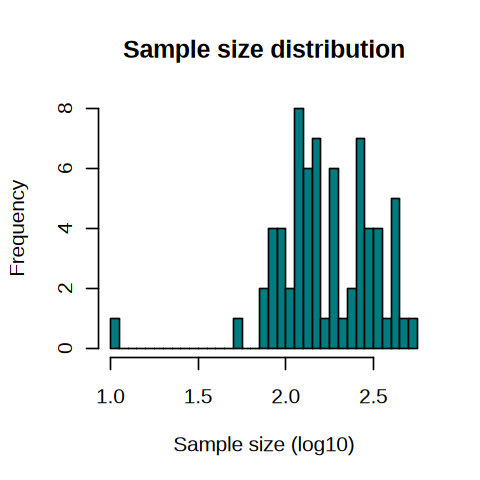

In [64]:
options(repr.plot.width=4, repr.plot.height=4)
hist(log10(sample_sums(ps)), breaks=50, main="Sample size distribution", xlab="Sample size (log10)", ylab="Frequency", col="#007c80")

We can see that samples with number of reads $\leq 10 ^ {1.5}$ (i.e. $\lesssim 32$) seem to be outliers. 
   Let's filter out the outliers and plot a new histogram.

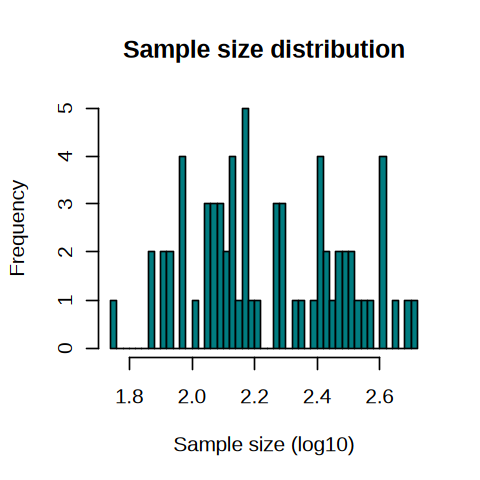

In [65]:
ps_good = subset_samples(ps, sample_sums(ps) > 32)
hist(log10(sample_sums(ps_good)), breaks=50, main="Sample size distribution", xlab="Sample size (log10)", ylab="Frequency", col="#007c80")

2) Remove singletons. Singletons are OTUs of size one, meaning that only one read was assigned to that OTU. These very low-abundance OTUs could be biologically real (belonging to the rare biosphere ([1](#reference_1))), or they could be false positives due to sequencing artefacts. Singletons observed in only one sample are more likely to be artefacts, and it is good practice to remove them from the OTUs counts table to avoid artificially over-estimating the OTUs richness. You can find more discussion about this in [Robert Edgar's blog](https://drive5.com/usearch/manual/singletons.html).


In [66]:
ps_final = filter_taxa(ps_good, function(x) sum(x) > 1, prune=TRUE)

3) Show some stats on the sequencing depth across samples.

[1] "The max difference in sequencing depth is 8.92857142857143"

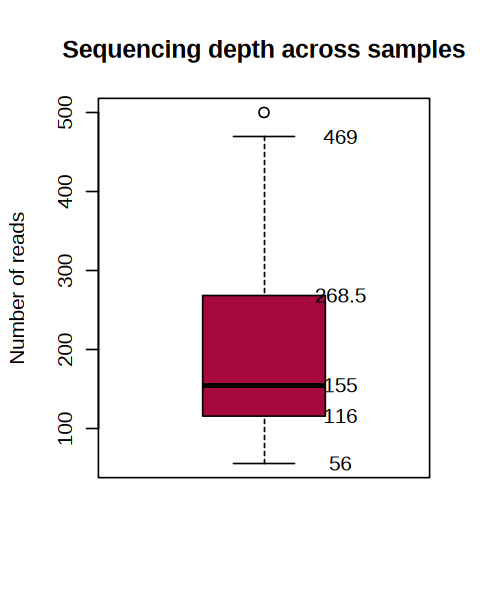

In [67]:
max_difference = max(sample_sums(ps_final))/min(sample_sums(ps_final))

sprintf("The max difference in sequencing depth is %s", max_difference)

options(repr.plot.width=4, repr.plot.height=5)

boxplot(sample_sums(ps_final), main="Sequencing depth across samples", xlab="", ylab="Number of reads", col="#a6093d")
text(y=boxplot.stats(sample_sums(ps_final))$stats, labels=boxplot.stats(sample_sums(ps_final))$stats, x=1.25)

An approximately 10-fold difference in the library sizes means that we will need to apply a normalization method before continuing with the analysis. The most common normalization methods used in microbiome count data are proportions and rarefaction. However, other methods originally developed to normalize RNA-seq counts have been adapted to differential-abundance analysis in microbiome data. A discussion about how to choose the right normalization method is out of the scope of this material, but the topic has been covered in multiple forums and scientific publications. Depending on the downstream analysis we intend to perform, different methods might be appropriate.

In the following examples we will show three popular ways of normalization: relative abundance, rarefaction and cummulative sum scaling.

### 2.2. Normalization by total sum scaling (TSS, relative abundance or proportions) <a id='part2_2'/>

The simplest way to normalize the differences in sample size is to transform the OTU counts table into relative abundance by dividing by the number of total reads of each sample. This type of normalization is also referred to as relative abundance or proportions. We use this normalization to compare taxonomic profiles, while alpha diversity indices are computed on the non-normalized matrix. The reason to do so is that we need a matrix of integer numbers as input.

1) Transform taxonomy raw-counts matrix into relative abundance.  <a id='part2_2_2'/>

In [68]:
relab_ps = transform_sample_counts(ps_final, function(x) x/sum(x))

2) Agglomerate taxonomy at Class rank and keep only the most abundant classes (threshold=1%, i.e. 0.01). In microbial data, we expect to observe abundance distributions with a long 'tail' of low-abundance organisms which often comprise the large majority of species. For this reason, once the matrix has been transformed to relative abundance, we will transform the taxonomic profile at a high taxonomic rank (Class), agglomerating the counts first and using an abundance threshold of 1% to avoid displaying too many unreadable categories in the plot.

In [69]:
psglom = tax_glom(relab_ps, "Class")
top_tss_ps = filter_taxa(psglom, function(x) mean(x) > 0.01, TRUE)

### 2.3. Normalization by subsampling (rarefaction) <a id='part2_3'/>

Rarefaction is an alternative to relative abundance normalization to obtain an adjusted OTUs count matrix. The method is based on a process of subsampling to the smallest library size in the data set. The algorithm randomly removes reads until the samples reach the same library size. Despite the apparent disadvantage of discarding information from the larger samples, rarefaction is quite popular in microbial ecology. The first step is to find the smallest sample size. We can use the number of observed OTUs in the original matrix to do so.

1) Find the smallest sample size.

In [71]:
df=as.data.frame(sample_sums(ps_final))
head(df[order( df[,1] ),],1)

[1] 56

2) Rarefying to the smallest sample.

In [72]:
ps_rare = rarefy_even_depth(ps_final, sample.size=56, replace=FALSE, rngseed=123, verbose=FALSE)

3) Aglomerate taxonomy at Class rank keeping the top 15 classes only.

In [73]:
psglom = tax_glom(ps_rare, "Class")
top15 = names(sort(taxa_sums(psglom), decreasing=TRUE)[1:15])
top15_rare_ps = prune_taxa(top15, psglom)

### 2.4. Normalization by cumulative sum scaling (CSS) <a id='part2_4'/>

The third normalization method we are going to apply is CSS. To do so, we will use the implementation on the `microbiomeMarker` library.
Cumulative sum scaling normalization calculates scaling factors as the cumulative sum of gene (or taxa) abundances up to a data-derived threshold. This method is based on the assumption that the count distributions in each sample are equivalent for low abundance genes up to a certain threshold. Only the segment of each sample's count distribution that is relatively invariant across samples is scaled by CSS.

1) Normalizing the OTU counts in the `ps_final` object.

In [74]:
ps_CSS = normalize(ps_final, method="CSS")

Default value being used.



2) Aglomerate taxonomy at Class rank and keep the top 15 classes only.

In [75]:
psglom = tax_glom(ps_CSS, "Class")
top15 = names(sort(taxa_sums(psglom), decreasing=TRUE)[1:15])
top15_css_ps = prune_taxa(top15, psglom)

### 2.5. Computing alpha diversity indices <a id='part2_5'/>

Alpha diversity is a measure of species diversity in a particular area or an ecosystem. In terms of microbial ecology, analyzing the sample diversity of sequencing data is commonly the first step in assessing differences between microbial environments. Some of the most popular alpha diversity indices reported in microbial community analyses are Chao, abundance-based coverage estimators (ACE), Simpson, and Shannon-Weaver.

Chao1 and ACE are nonparametric estimators that describe diversity as the max number of expected species in the sample (species richness). They consider the proportion of species that have been observed before ("recaptured") to those that are observed only once. Both Chao1 and ACE underestimate true richness at low sample sizes.


On the other hand, Simpson and Shannon-Weaver, consider relative abundances and depends on both, species richness and the evenness (or equitableness), with which individuals are distributed among the different species. However, both metrics have specific biases. The Shannon-Weaver index places a greater weight on species richness, whereas the Simpson index considers evenness more than richness in its measurement. 


More discussion and examples illustrating how sample size and normalization methods can affect alpha diversity metrics in references [4](#reference_4) and [5](#reference_5). 

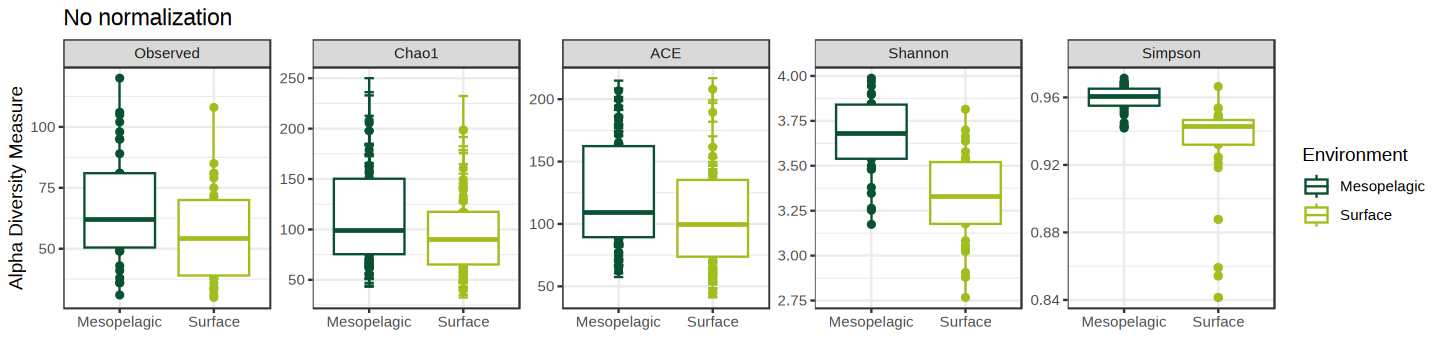

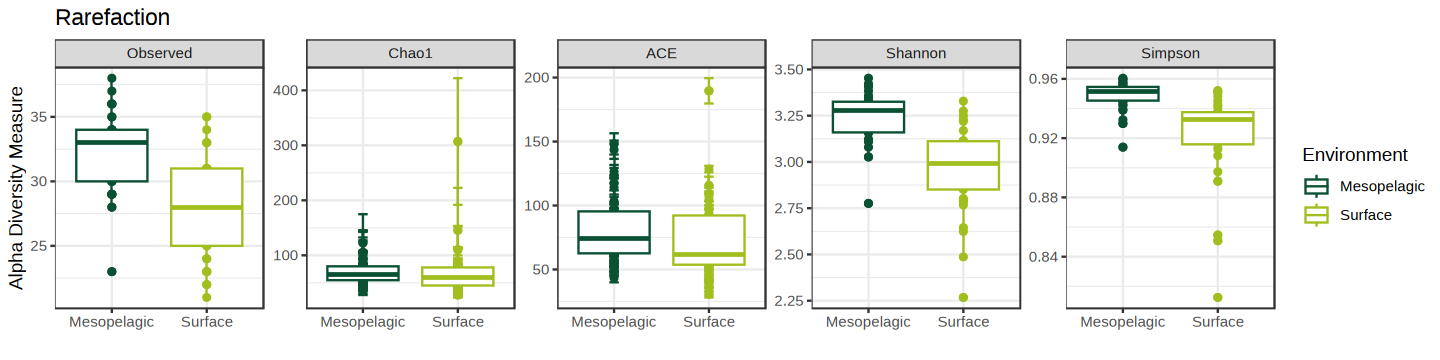

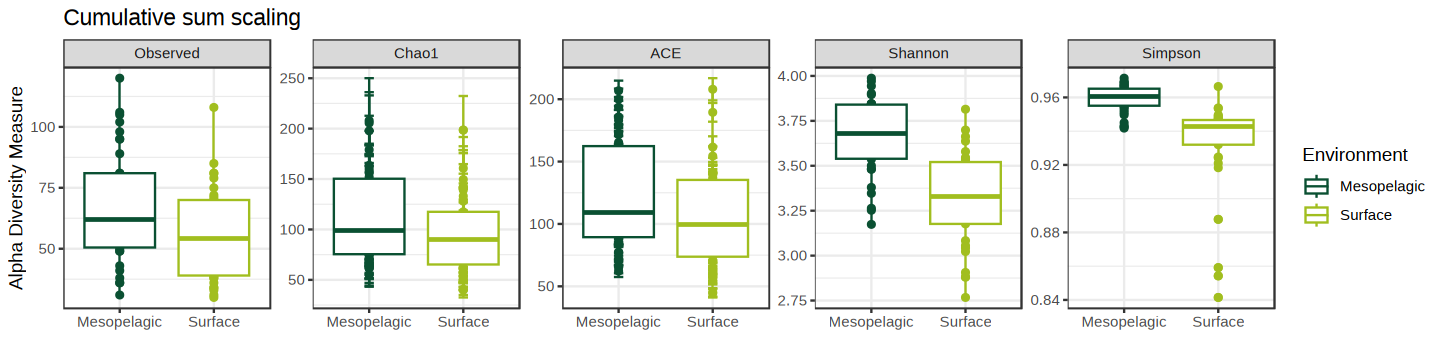

In [76]:
options(repr.plot.width=12, repr.plot.height=3)

### No normalization
plot_richness(ps_final, x="env_label", color="env_label", title="No normalization", measures=c("Observed", "Chao1", "ACE", "Shannon", "Simpson")) + 
    geom_boxplot() + 
    theme_bw() + 
    scale_color_manual(values=c("#0a5032", "#a1be1f")) + 
    labs(x='', color = "Environment")

### Rarefaction
plot_richness(ps_rare, x="env_label", color="env_label", title="Rarefaction", measures=c("Observed", "Chao1", "ACE", "Shannon", "Simpson")) + 
    geom_boxplot() + 
    theme_bw() + 
    scale_color_manual(values=c("#0a5032", "#a1be1f")) + 
    labs(x='', color = "Environment")

### Cumulative sum scaling
plot_richness(ps_CSS, x="env_label", color="env_label", title="Cumulative sum scaling", measures=c("Observed", "Chao1", "ACE", "Shannon", "Simpson")) + 
    geom_boxplot() + 
    theme_bw() + 
    scale_color_manual(values=c("#0a5032", "#a1be1f")) + 
    labs(x='', color="Environment")

### 2.6. Community profile visualization <a id='part2_6'/>

Visualise the taxonomic profile in barplots at Class rank in two modes.

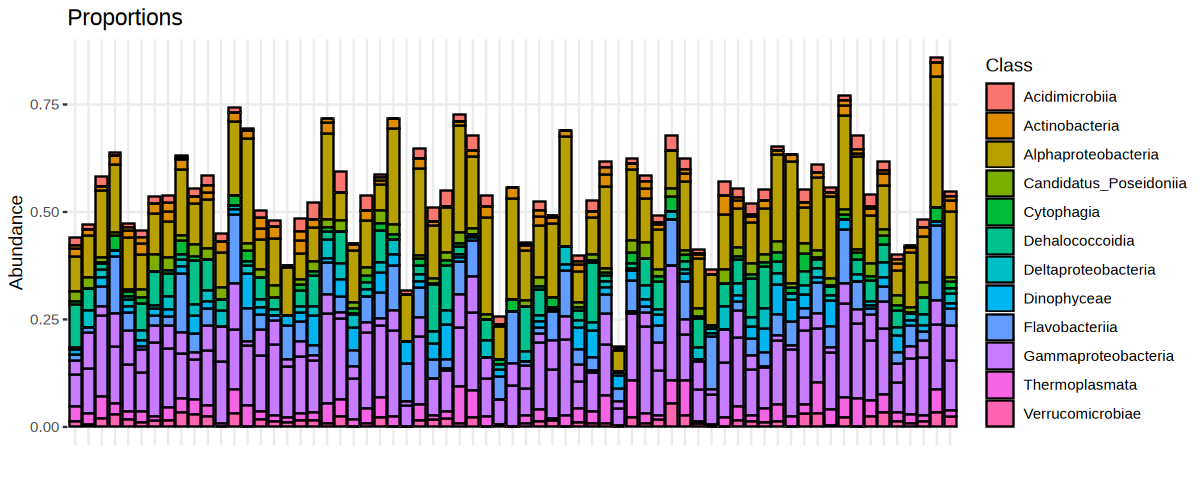

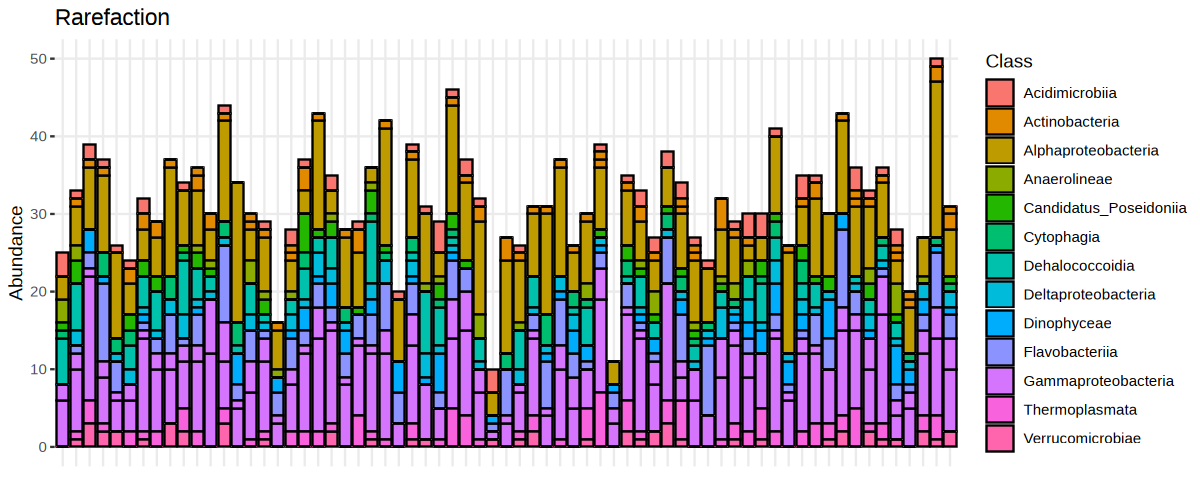

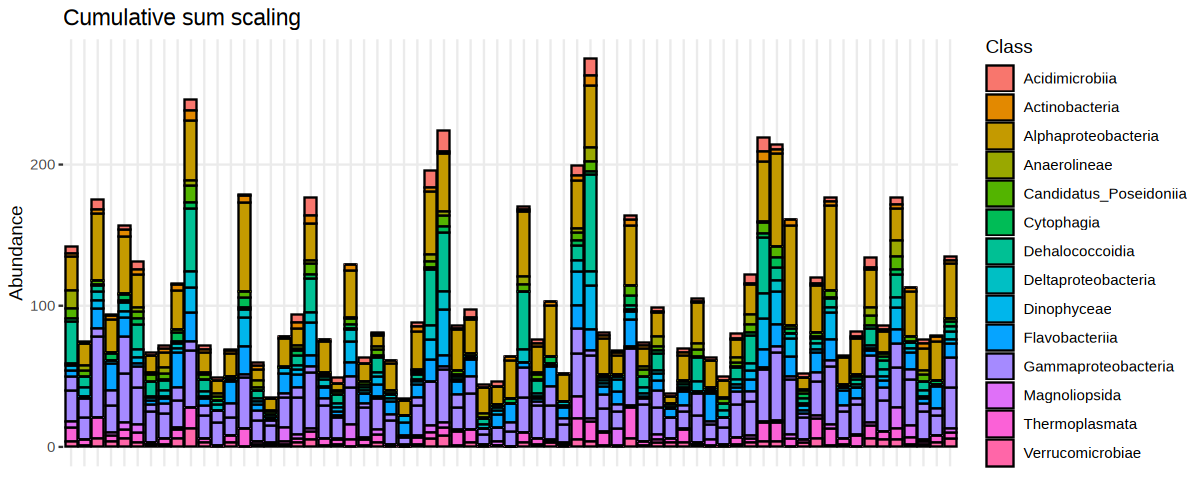

In [77]:
options(repr.plot.width=10, repr.plot.height=4)

### Proportions
plot_bar(top_tss_ps, fill = "Class", title="Proportions") + 
    theme(axis.text.x=element_blank(), axis.ticks.x=element_blank(), panel.background=element_rect(fill=NA), panel.grid.major=element_line(colour="#ebebeb")) + 
    labs(x='')

### Rarefaction
plot_bar(top15_rare_ps, fill="Class", title="Rarefaction") + 
    theme(axis.text.x=element_blank(), axis.ticks.x=element_blank(), panel.background=element_rect(fill=NA), panel.grid.major=element_line(colour="#ebebeb")) + 
    labs(x=NULL)

### Cumulative sum scaling
plot_bar(top15_css_ps, fill="Class", title="Cumulative sum scaling") + 
    theme(axis.text.x=element_blank(), axis.ticks.x=element_blank(), panel.background=element_rect(fill=NA), panel.grid.major=element_line(colour="#ebebeb")) + 
    labs(x=NULL)

By naked eye, we can see that the profiles looks quite different. Let's take a deeper look at some interesting Classes to check how the abundance change depending on the normalization method.

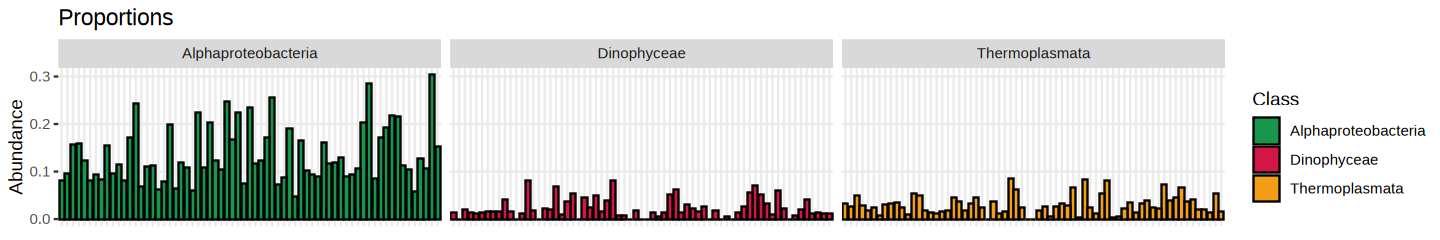

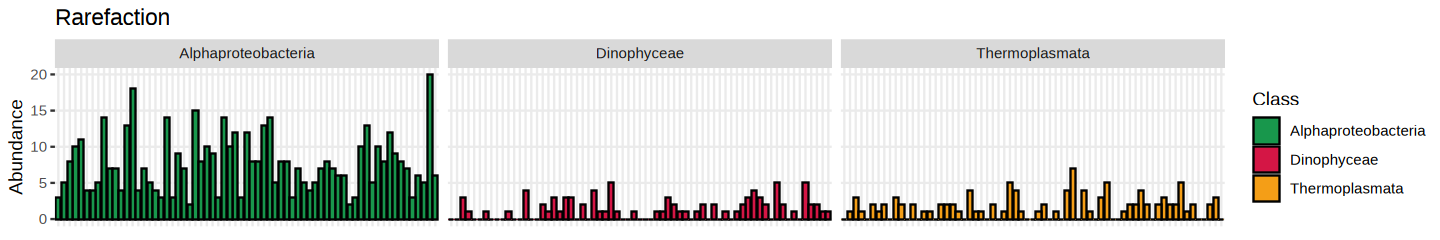

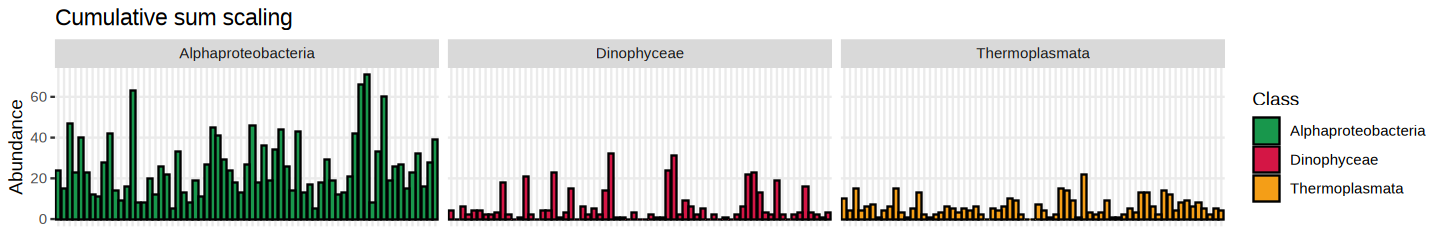

In [78]:
options(repr.plot.width=12, repr.plot.height=2)

### Proportions
plot_bar(subset_taxa(top_tss_ps, Class=='Alphaproteobacteria' | Class=='Dinophyceae' | Class=='Thermoplasmata' ), fill = "Class", title="Proportions") + 
    facet_wrap(~Class) + 
    scale_fill_manual(values=c("#18974c","#d41645","#f49e17")) +
    theme(axis.text.x=element_blank(), axis.ticks.x=element_blank(), panel.background=element_rect(fill=NA), panel.grid.major=element_line(colour="#ebebeb")) + 
    labs(x=NULL)

### Rarefaction
plot_bar(subset_taxa(top15_rare_ps, Class=='Alphaproteobacteria' | Class=='Dinophyceae' | Class=='Thermoplasmata' ), fill="Class", title="Rarefaction") + 
    facet_wrap(~Class) + 
    scale_fill_manual(values=c("#18974c","#d41645","#f49e17")) +
    theme(axis.text.x=element_blank(), axis.ticks.x=element_blank(), panel.background=element_rect(fill=NA), panel.grid.major=element_line(colour="#ebebeb")) + 
    labs(x=NULL)

### Cumulative sum scaling
plot_bar(subset_taxa(top15_css_ps, Class=='Alphaproteobacteria' | Class=='Dinophyceae' | Class=='Thermoplasmata' ), fill="Class", title="Cumulative sum scaling") + 
    facet_wrap(~Class) + 
    scale_fill_manual(values=c("#18974c","#d41645","#f49e17")) +
    theme(axis.text.x=element_blank(), axis.ticks.x=element_blank(), panel.background=element_rect(fill=NA), panel.grid.major=element_line(colour="#ebebeb")) + 
    labs(x=NULL)

## Part 3. Exploring KEGG pathways <a id='part3'/>

In this section we use MGnifyR again to fetch functional annotation results generated through the [MGnify metagenomic analyisis pipelines](https://docs.mgnify.org/src/docs/analysis.html). Then we show how to generate a pathways visualization using [Pathview](https://bioconductor.org/packages/release/bioc/html/pathview.html) in R.

Functional annotations of a metagenomic assembly are based on comparison of proteins coding sequences found in the assembly's contigs to functional databases such as KEGG orthologs. KEGG modules are pathways of KEGG orthologs, and a pathway's completeness is determined by the presence or absence of KEGG orthologs. A bespoke [pathway completeness](https://github.com/EBI-Metagenomics/kegg-pathways-completeness-tool) is used to assign pathway completeness.

In [84]:
# Loading libraries:
suppressMessages({
    library(ALDEx2)
    library(data.table)
    library(dplyr)
    library(IRdisplay)
    library(KEGGREST)
    library(MGnifyR)   
    library(pathview)
    library(tidyjson)
    library(IRdisplay)
})
source("lib/variable_utils.r")
source("lib/kegg_pathways_utils.r")

In [87]:
# Create your session mgnify_client object
mg = mgnify_client(usecache = T, cache_dir = '/home/jovyan/.mgnify_cache')

In [88]:
# Setting tables and figures size to display (these will be reset later):
options(repr.matrix.max.cols=150, repr.matrix.max.rows=500)
options(repr.plot.width=4, repr.plot.height=4)

### 3.1. Fetch data from MGnify & Pathways Selection <a id='part3_1'/>

In [95]:
PATHWAY_STUDY_IDS <- get_variable_from_link_or_input('PATHWAY_STUDY_IDS', name =  'Study Accession', default = 'MGYS00002008')
PATHWAY_STUDY_IDS <- c(strsplit(PATHWAY_STUDY_IDS, ",")[[1]])
print(paste("Using", PATHWAY_STUDY_IDS, "as Study Accession"))

Type a Study Accession [default: MGYS00002008] 


Using "MGYS00002008" as Study Accession
[1] "Using MGYS00002008 as Study Accession"


In [130]:
# Custom Pathways Selection

# Most general pathways include
# Glycolysis / Gluconeogenesis, Citrate cycle (TCA cycle), Pentose phosphate pathway, 
# Fatty acid biosynthesis, Pyrimidine metabolism, Oxidative phosphorylation
# Type 00010,00020,00030,00061,01232,00240,00190 in the prompt below to plot these

# Alternatively to look at only pathways relating to energy metabolism
# Type 00190,00195,00196,00710,00720,00680,00910,00920 in the prompt below to plot these

CUSTOM_PATHWAY_IDS <- PathwaysSelection()

#### Pathways Selection :


- For the most general & most complete pathways, input 'G'


- Press Enter to generate the most complete pathways


- To add custom pathways, input pathway numbers (ex: 00053,01220)

Type a Pathways Accession [default: ] 00190,00195,00196,00710,00720,00680,00910,00920


Using "00190,00195,00196,00710,00720,00680,00910,00920" as Pathways Accession



Using 00190  -  Oxidative phosphorylation  :  https://www.kegg.jp/pathway/map00190 as a Custom Pathway
Using 00195  -  Photosynthesis  :  https://www.kegg.jp/pathway/map00195 as a Custom Pathway
Using 00196  -  Photosynthesis - antenna proteins  :  https://www.kegg.jp/pathway/map00196 as a Custom Pathway
Using 00710  -  Carbon fixation by Calvin cycle  :  https://www.kegg.jp/pathway/map00710 as a Custom Pathway
Using 00720  -  Other carbon fixation pathways  :  https://www.kegg.jp/pathway/map00720 as a Custom Pathway
Using 00680  -  Methane metabolism  :  https://www.kegg.jp/pathway/map00680 as a Custom Pathway
Using 00910  -  Nitrogen metabolism  :  https://www.kegg.jp/pathway/map00910 as a Custom Pathway
Using 00920  -  Sulfur metabolism  :  https://www.kegg.jp/pathway/map00920 as a Custom Pathway



1. Fetch the analysis accession list using the study accessions. 

In [131]:
output <- capture.output({
  all_accessions <- mgnify_analyses_from_studies(mg, PATHWAY_STUDY_IDS)
  all_metadata <- mgnify_get_analyses_metadata(mg, all_accessions)
})

2. We will keep just one analysis accession (you can select a different accesison if preferred), fetch the KEGG Orthologs count table from the MGnify API. Transform it from JSON into a matrix.

In [132]:
accession = "MGYA00590491"
ko_loc = paste0('analyses/',accession,'/kegg-orthologs')
accession

[1] "MGYA00590491"

In [133]:
ko_json = mgnify_retrieve_json(mg, path = ko_loc)
ko_data = as.data.frame(ko_json %>% spread_all)[ , c("attributes.accession", "attributes.count")]
ko_data = data.frame(ko_data, row.names=1)
colnames(ko_data)[1] = 'counts'
ko_matrix = data.matrix(ko_data)
head(ko_matrix, 3)

,counts
K02014,2036
K00626,1535
K03701,1347


3. Fetch the KEGG Modules completeness table and filter out modules with completeness < 100%.

In [134]:
comp_loc = paste0('analyses/',accession,'/kegg-modules')
ko_comp_json = mgnify_retrieve_json(mg, path = comp_loc)
ko_comp = as.data.frame(ko_comp_json %>% spread_all)
modules = ko_comp[ko_comp$attributes.completeness == 100,][, c("attributes.accession")]
modules

[1] "M00001" "M00002" "M00003" "M00004" "M00005" "M00006" "M00007" "M00008"
  [9] "M00009" "M00010" "M00011" "M00012" "M00015" "M00016" "M00017" "M00018"
 [17] "M00019" "M00020" "M00021" "M00022" "M00023" "M00026" "M00027" "M00028"
 [25] "M00033" "M00034" "M00035" "M00036" "M00038" "M00040" "M00044" "M00045"
 [33] "M00046" "M00048" "M00049" "M00050" "M00051" "M00052" "M00055" "M00063"
 [41] "M00064" "M00075" "M00082" "M00083" "M00086" "M00087" "M00088" "M00089"
 [49] "M00091" "M00093" "M00095" "M00096" "M00097" "M00100" "M00112" "M00115"
 [57] "M00117" "M00118" "M00119" "M00120" "M00121" "M00122" "M00123" "M00124"
 [65] "M00125" "M00126" "M00127" "M00128" "M00133" "M00134" "M00135" "M00140"
 [73] "M00142" "M00143" "M00144" "M00145" "M00148" "M00149" "M00151" "M00153"
 [81] "M00155" "M00156" "M00157" "M00159" "M00161" "M00163" "M00165" "M00166"
 [89] "M00167" "M00168" "M00169" "M00172" "M00176" "M00307" "M00338" "M00345"
 [97] "M00346" "M00364" "M00365" "M00366" "M00367" "M00373" "M00376" "M00378"
[105] "M00415" "M00417" "M00432" "M00527" "M00530" "M00531" "M00532" "M00533"
[113] "M00535" "M00545" "M00546" "M00548" "M00549" "M00552" "M00554" "M00555"
[121] "M00569" "M00570" "M00572" "M00579" "M00580" "M00595" "M00596" "M00597"
[129] "M00631" "M00632" "M00641" "M00741" "M00745" "M00793" "M00844" "M00846"
[137] "M00854" "M00855" "M00866" "M00868" "M00880"

---


### 3.2. Select the most complete pathways <a id='part3_2'/>

In [135]:
# Setting up function that collects KEGG pathways for a given list of IDs, excluding chemical structure & global maps

collect_pathways <- function(ids_list) {
    pathways = list()
    for (id in ids_list) { 
        current_pathway = as.list(keggLink("pathway", id))
        for (index in grep("map", current_pathway)) {        
            clean_id = gsub("*path:", "", current_pathway[index])
            # Discarding chemical structure (map010XX), global (map011XX), and overview (map012XX) maps
            prefix = substring(clean_id, 1, 6)
            if(is.na(match("map010", prefix)) & is.na(match("map011", prefix)) & is.na(match("map012", prefix)) ){
                pathways = append(pathways, clean_id)
            }
        }
    }
    return(pathways)
}

1. Now we need to collect the list of template pathways where these complete modules can be drawn. This step takes less than 1 minute to run.

In [136]:
md_pathways = collect_pathways(modules)
head(md_pathways)

[[1]]
[1] "map00010"

[[2]]
[1] "map00010"

[[3]]
[1] "map00010"

[[4]]
[1] "map00020"

[[5]]
[1] "map00030"

[[6]]
[1] "map00030"

2. In order to draw the most complete pathways maps, we will use the list of templates we obtained in the previous step and select only pathways having all their constituent modules.

In [120]:
# Counting the number of modules we have in each pathway
our_pathways_counts = list()
for (path_element in md_pathways) {
    if (path_element %in% names(our_pathways_counts)) {
        new_value = our_pathways_counts[[path_element]] + 1
        our_pathways_counts[path_element] = new_value       
    } else {
        our_pathways_counts[path_element] = 1 
    }
}

# Counting the number of modules expected in each pathway
u_pathways = unique(md_pathways)
exp_pathways_counts = list()
for (path in u_pathways) {
    mod_count = length(as.list(keggLink("module", path)))
    exp_pathways_counts[path] = mod_count 
}

# Selecting the pathways having all their constituent modules. We remove the 'map' prefix as pathview doesn't like it
to_draw = list()
for (pathway in names(our_pathways_counts)) {
    our_value = our_pathways_counts[[pathway]]
    exp_value = exp_pathways_counts[[pathway]]
    ratio =  our_value / exp_value
    if (ratio == 1) {
        nude_id =  gsub("map", "", pathway)
        to_draw = append(to_draw, nude_id)   
    }
}


# Adding the custom pathways to to_draw if not present already
for (pathway in CUSTOM_PATHWAY_IDS){
    if (!(pathway %in% to_draw)) {
    to_draw = append(to_draw, pathway)
        }
    }

In [137]:
# printing name of the pathways to be drawn
for (pathway in to_draw){
    print(paste(pathway, "-->", get_pathway_info(pathway)[1]," : ",get_pathway_info(pathway)[2], sep=" "))
}

[1] "00190 --> Oxidative phosphorylation  :  https://www.kegg.jp/pathway/map00190"
[1] "00195 --> Photosynthesis  :  https://www.kegg.jp/pathway/map00195"
[1] "00196 --> Photosynthesis - antenna proteins  :  https://www.kegg.jp/pathway/map00196"
[1] "00710 --> Carbon fixation by Calvin cycle  :  https://www.kegg.jp/pathway/map00710"
[1] "00720 --> Other carbon fixation pathways  :  https://www.kegg.jp/pathway/map00720"
[1] "00680 --> Methane metabolism  :  https://www.kegg.jp/pathway/map00680"
[1] "00910 --> Nitrogen metabolism  :  https://www.kegg.jp/pathway/map00910"
[1] "00920 --> Sulfur metabolism  :  https://www.kegg.jp/pathway/map00920"


---

### 3.3. Ready to draw! <a id='part3_3'/>

1. As we are plotting absence/presence, we set the number of bins = 2, the scale in one direction, and use 1 as limit.

This can take a couple of minutes depending on the number of pathways.

In [138]:
suppressMessages({
for (p in to_draw) {
    pathview(gene.data = ko_matrix, 
             species = "ko", 
             pathway.id = p, 
             bins=c(2, 2), 
             both.dirs = FALSE, 
             limit = c(1,1), 
             mid = c("#ffffff" , "#ffffff"), 
             high = c("#02b3ad" , "#02b3ad")
    )
}
})

2. Clear the current working directory, and display all the generated figures that are stored at the `pathway_plots/` directory. 

Oxidative phosphorylation

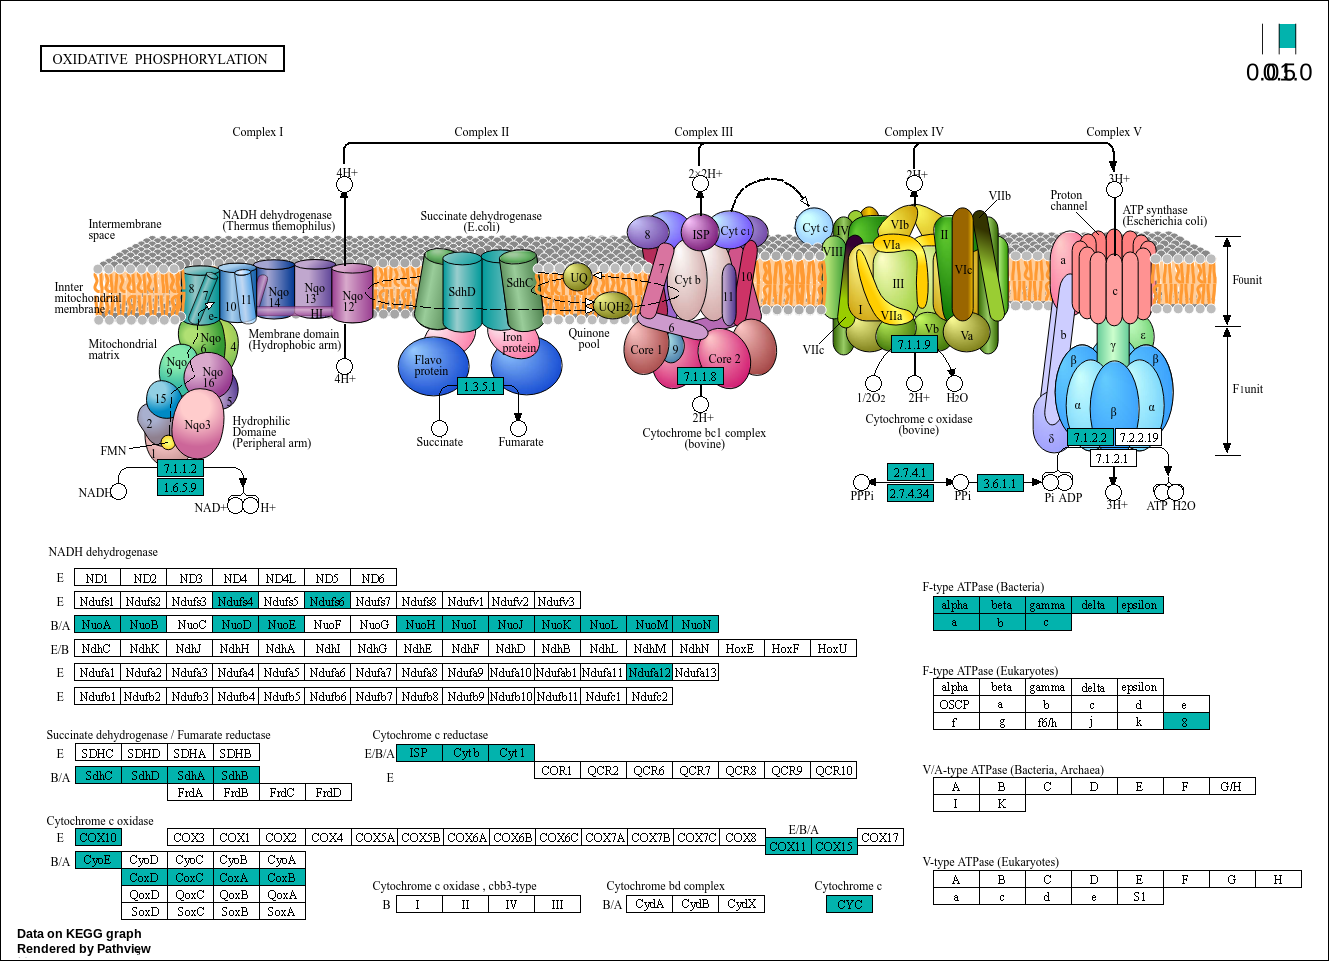

Photosynthesis

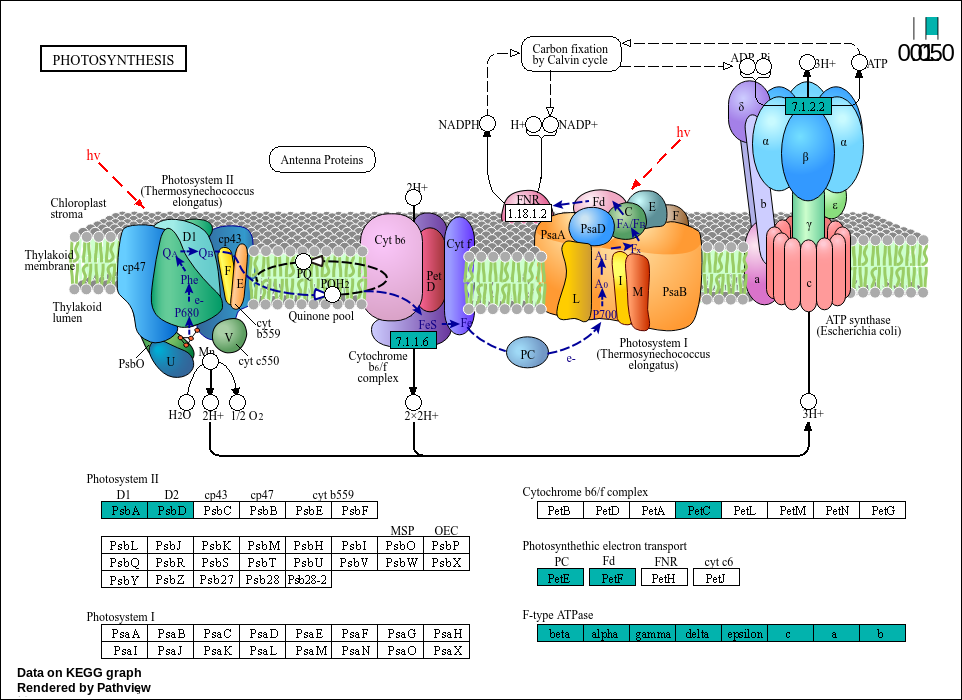

Photosynthesis - antenna proteins

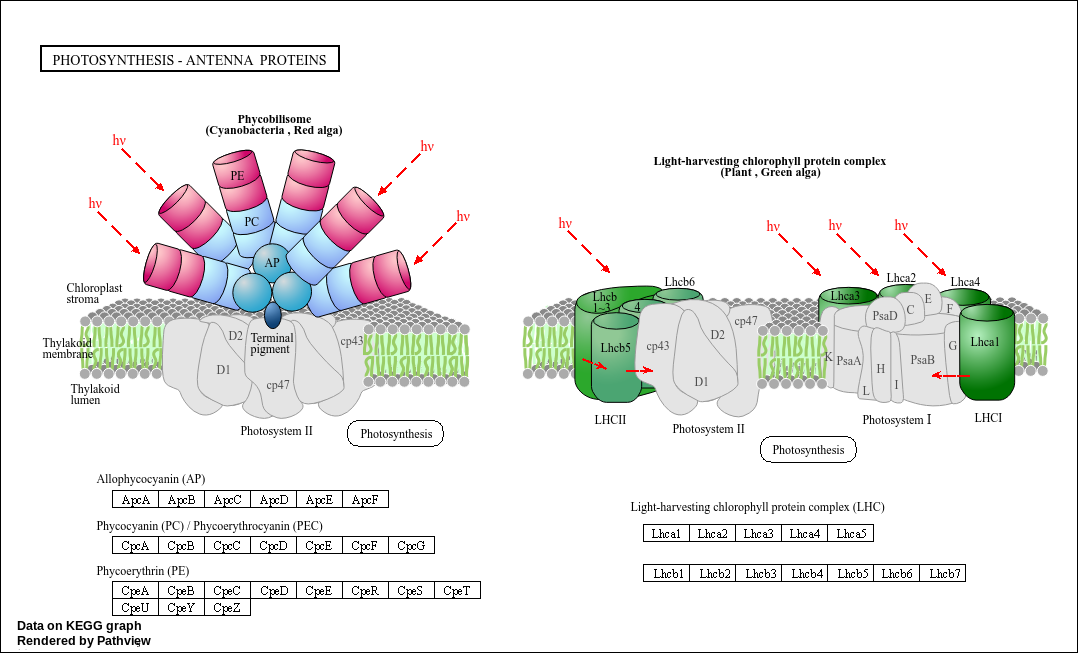

Methane metabolism

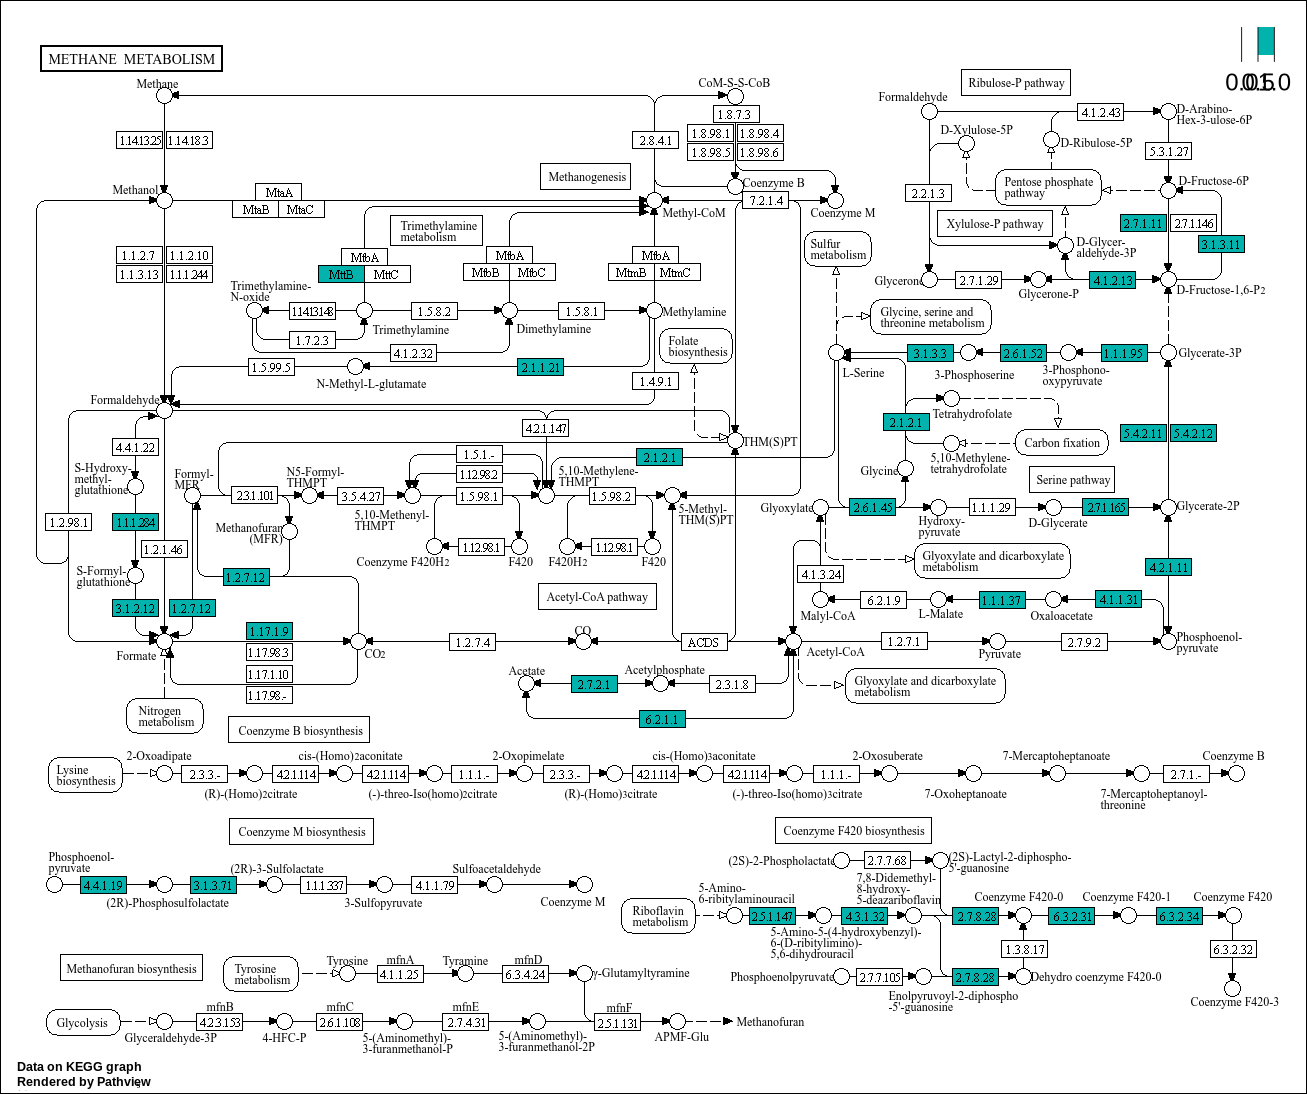

Carbon fixation by Calvin cycle

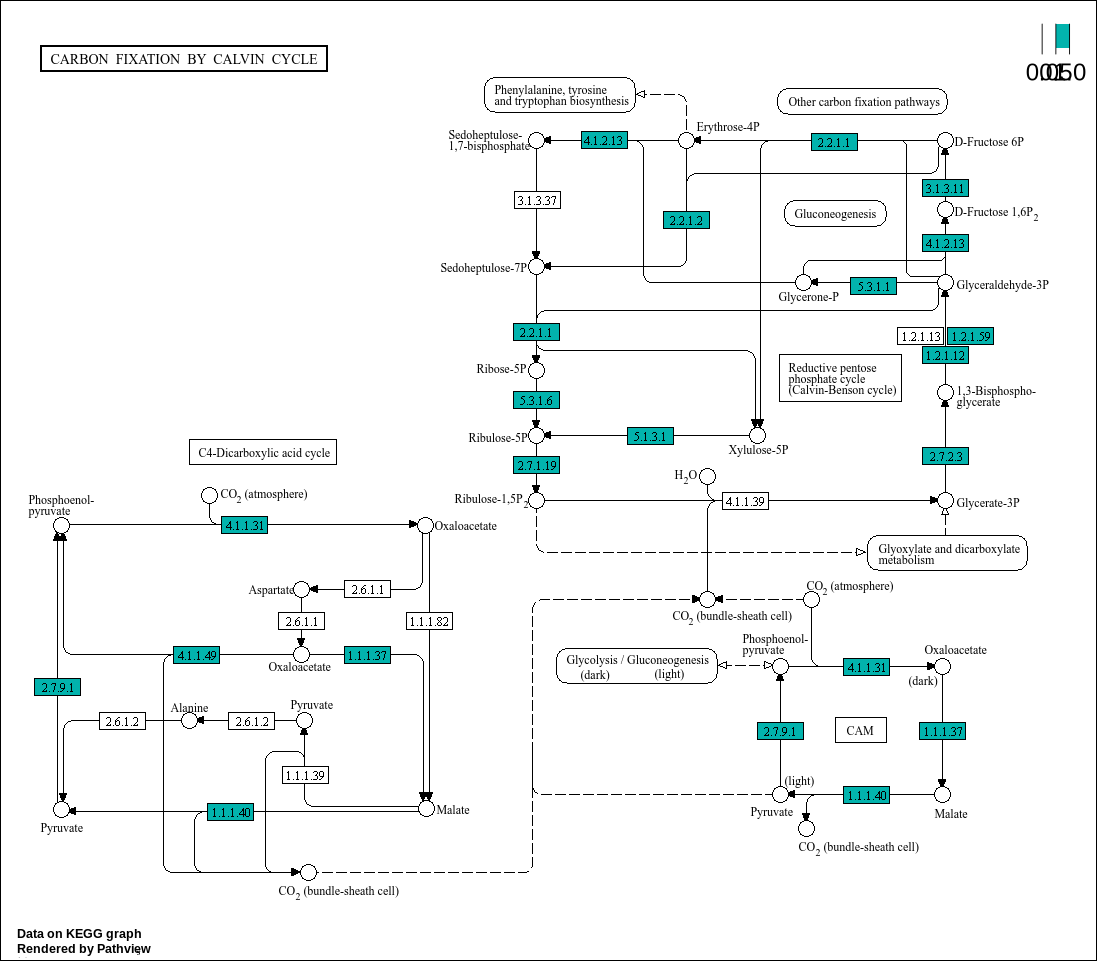

Other carbon fixation pathways

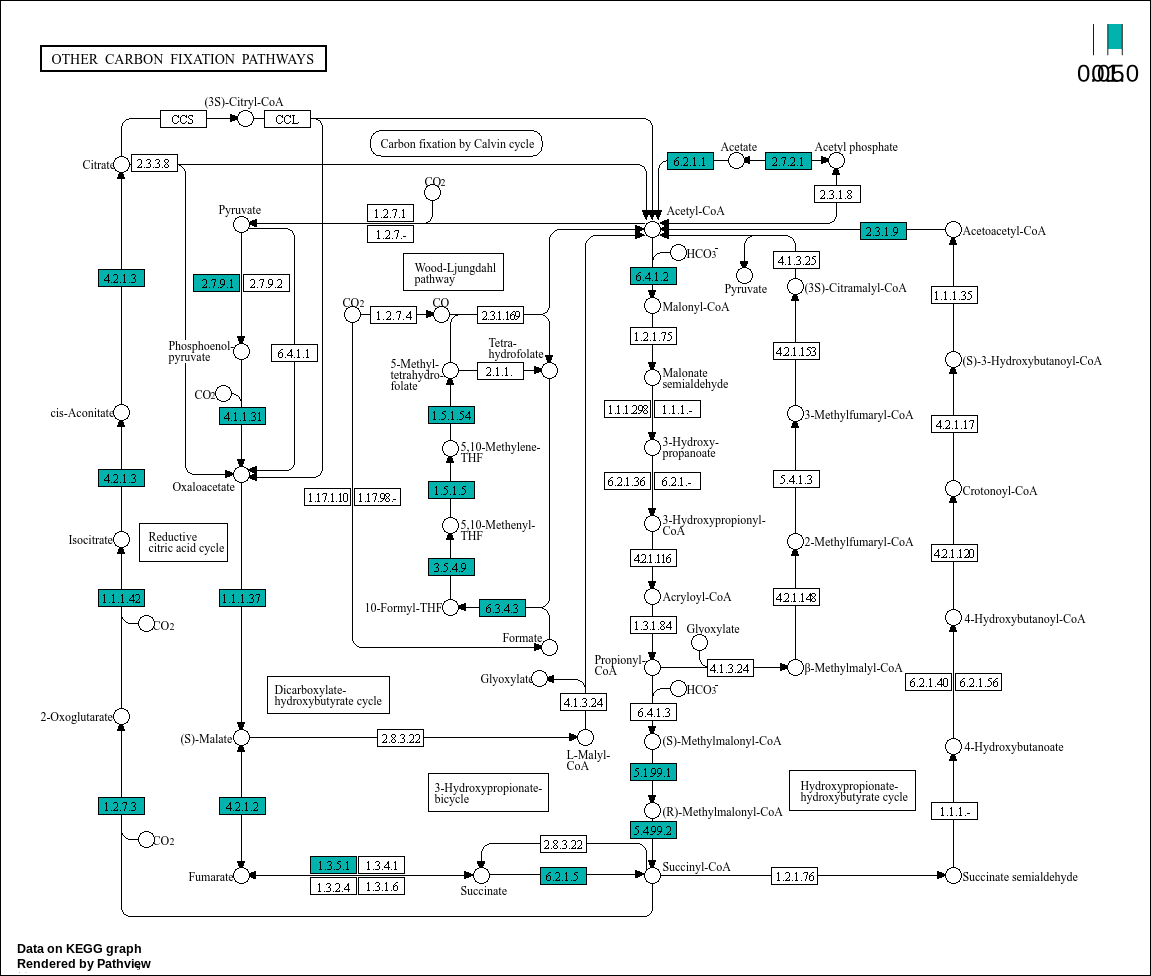

Nitrogen metabolism

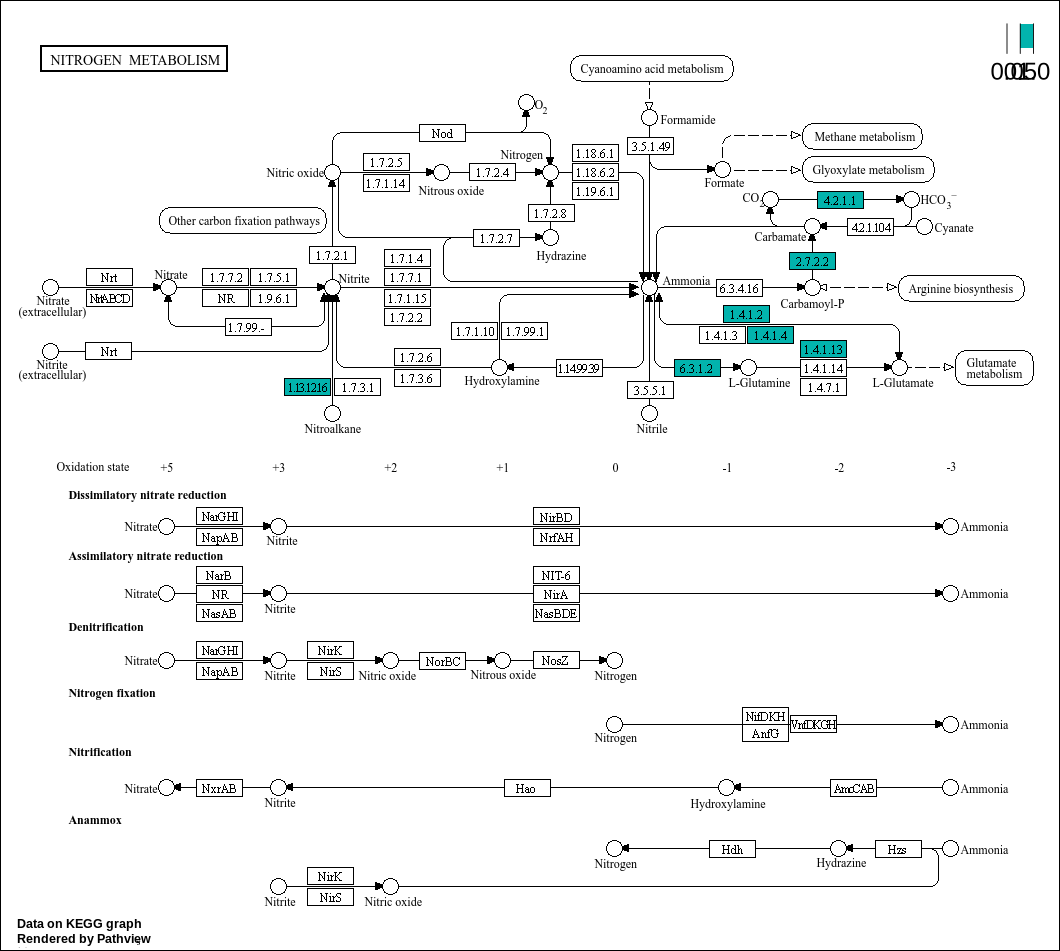

Sulfur metabolism

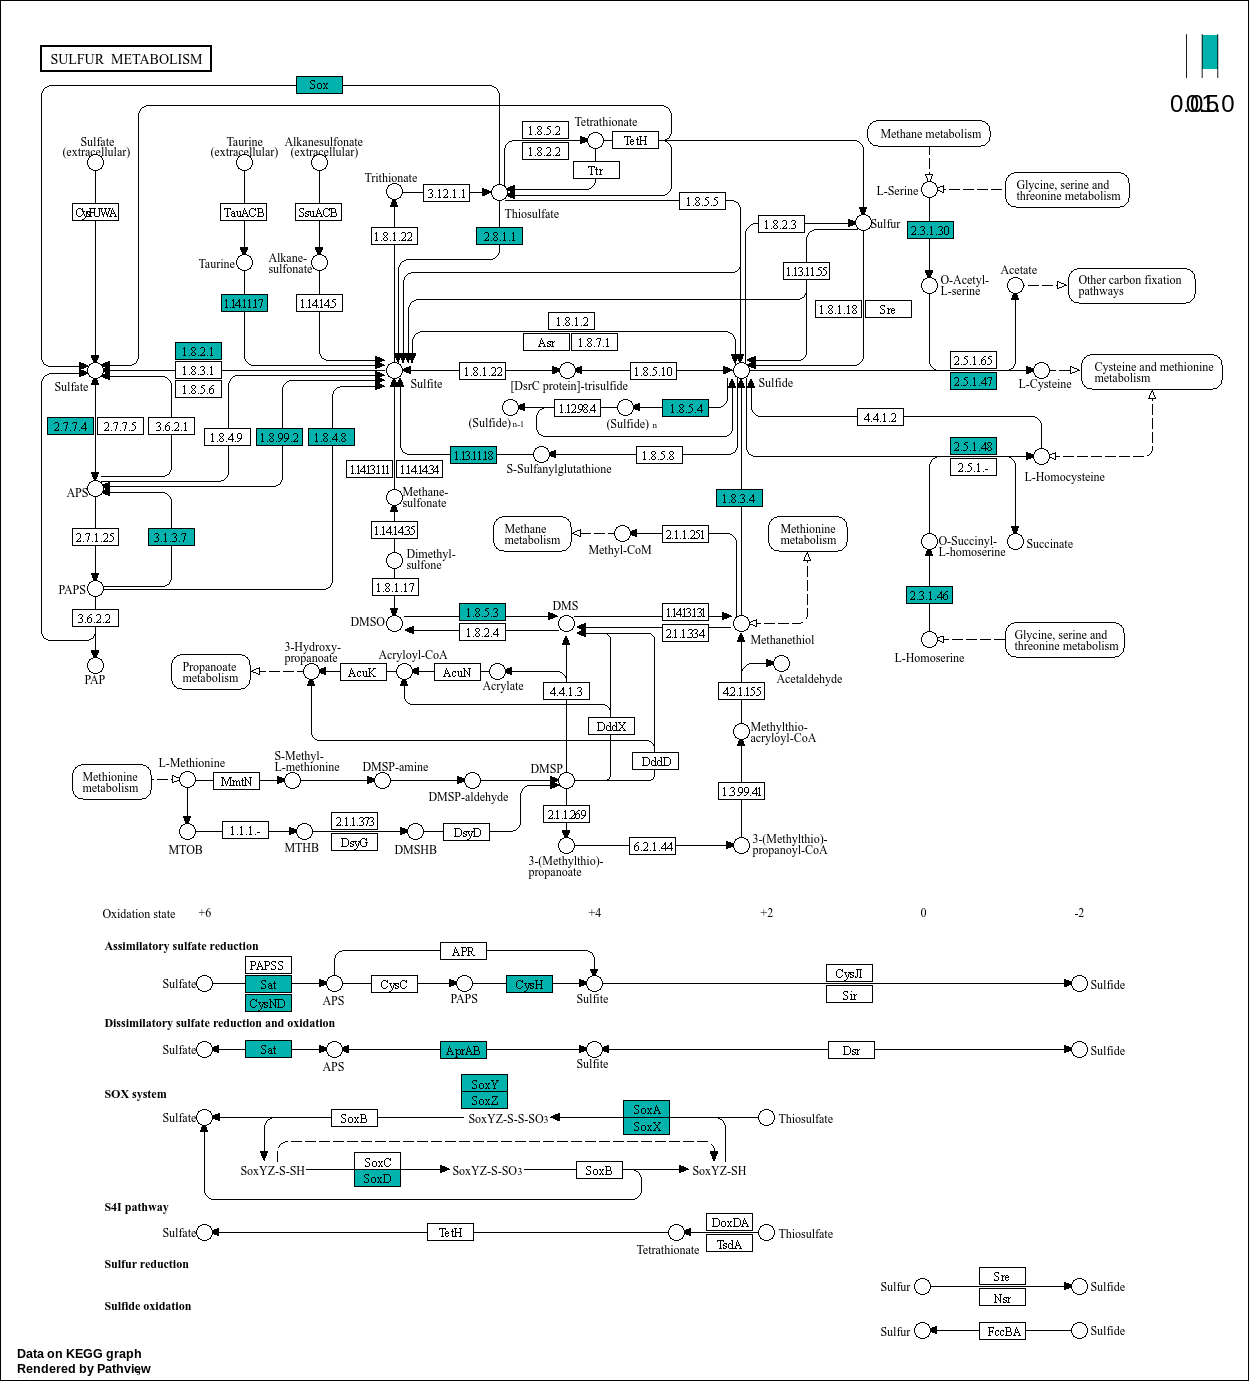

In [139]:
generatePathwayPlots()

### References: <a id='refs'/></a>

<a id="reference_1">1.</a> Lynch, M., Neufeld, J. Ecology and exploration of the rare biosphere. Nat Rev Microbiol 13:217–229 (2015) [DOI:10.1038/nrmicro3400](https://doi.org/10.1038/nrmicro3400)
    
<a id="reference_2">2.</a> McKnight, DT., Huerlimann, R., Bower, DS. et al. Methods for Normalizing Microbiome Data: An Ecological Perspective. Methods in Ecology and Evolution / British Ecological Society 10(3):389–400 (2019) [DOI:10.1111/2041-210X.13115](https://doi.org/10.1111/2041-210X.13115)

<a id="reference_3">3.</a> McMurdie, PJ., Holmes, S. Waste Not, Want Not: Why Rarefying Microbiome Data Is Inadmissible. PLoS Comput Biol 10(4):e1003531 (2014) [DOI:10.1371/journal.pcbi.1003531](https://doi.org/10.1371/journal.pcbi.1003531)

<a id="reference_4">4.</a> Willis, A. Rarefaction, Alpha Diversity, and Statistics. Front. Microbiol. Sec. Terrestrial Microbiology 10:2407 (2019) [DOI:10.3389/fmicb.2019.02407](https://doi.org/10.3389/fmicb.2019.02407)
    
<a id="reference_5">5.</a> Kim, BR., Shin, J., Guevarra, R. et al. Deciphering Diversity Indices for a Better Understanding of Microbial Communities. J Microbiol Biotechnol 28;27(12):2089-2093 (2017) [DOI:10.4014/jmb.1709.09027](https://doi.org/10.4014/jmb.1709.09027)

Documentation and more MGnifyR code and exercises available [on GitHub](https://beadyallen.github.io/MGnifyR/) and [on rdrr site](https://rdrr.io/github/beadyallen/MGnifyR/f/vignettes/MGnifyR.Rmd)

Phyloseq tutorials available [on GitHub](https://joey711.github.io/phyloseq/index.html)

Pathview [documentation](https://pathview.uncc.edu/overview#kegg_view)

KEGGREST is a Bioconductor package that provides programmatic access to the KEGG database. More about [KEGGREST](http://www.bioconductor.org/packages/release/bioc/vignettes/KEGGREST/inst/doc/KEGGREST-vignette.html)

Method for [KEGG pathway calculation](https://github.com/EBI-Metagenomics/kegg-pathways-completeness-tool) in MGnify